## Adapter (ang. Adapter)

**Typ**: strukturalny \
**Zakres**: klasowy (adapter klasowy) / obiektowy (adapter obiektowy) \
**Inne nazwy**: nakładka, wrapper

<div style="border: solid 1px;padding: 20px;text-align: center">
    Wzorzec <b>adapter</b> konwertuje interfejs klasy na inny interfejs, oczekiwany przez klienta. Umożliwia współpracę klas, które normalnie nie mogłyby współdziałać ze względu na niekompatybilne interfejsy.
</div>

### Analogia z życia codziennego

Wyobraź sobie, że lecisz z Polski do USA. Twoja polska wtyczka (2 piny, 230V) nie pasuje do amerykańskiego gniazdka (3 piny, 110V). Potrzebujesz **adaptera** - małego urządzenia, które:
- Ma interfejs pasujący do polskiej wtyczki
- Ma interfejs pasujący do amerykańskiego gniazdka
- Przekłada jeden interfejs na drugi

To dokładnie robi wzorzec Adapter w programowaniu!

### Problem

Mamy system do przetwarzania płatności. Nasz kod oczekuje interfejsu `PaymentProcessor` z metodą `process_payment(amount)`.

In [ ]:
# Interfejs oczekiwany przez nasz system
class PaymentProcessor:
    def process_payment(self, amount: float):
        pass


# Nasza istniejąca implementacja
class StripePayment(PaymentProcessor):
    def process_payment(self, amount: float):
        print(f"Przetwarzam płatność {amount} zł przez Stripe")


# Kod klienta - używa PaymentProcessor
def checkout(processor: PaymentProcessor, amount: float):
    print(f"Rozpoczynam płatność...")
    processor.process_payment(amount)
    print("Płatność zakończona!\n")


# Użycie
stripe = StripePayment()
checkout(stripe, 100.0)

Teraz chcemy dodać PayPal. Problem: biblioteka PayPal ma **inny interfejs** - używa metody `make_payment(dollars)` zamiast `process_payment(amount)`.

In [ ]:
# Zewnętrzna biblioteka PayPal - INNY interfejs
class PayPalAPI:
    def make_payment(self, dollars: float):
        print(f"PayPal: przetwarzanie ${dollars}")


# Problem: PayPal nie implementuje PaymentProcessor!
paypal = PayPalAPI()
# checkout(paypal, 100.0)  # To nie zadziała!
# AttributeError: 'PayPalAPI' object has no attribute 'process_payment'

**Problem:**
- Nasz kod oczekuje: `process_payment(amount)`
- PayPal dostarcza: `make_payment(dollars)`
- **Interfejsy są niekompatybilne!**

Nie możemy zmienić biblioteki PayPal (kod zewnętrzny). Nie chcemy zmieniać całego naszego systemu. **Potrzebujemy adaptera!**

Istnieją dwa różny typy adapterów, które realizują to samo zadanie w trochę inny sposób:
- Adapter obiektowy
- Adapter klasowy

Zacznijmy od adaptera obiektowego

## Rozwiązanie 1: Adapter Obiektowy (Object Adapter)

Adapter obiektowy używa **kompozycji** - zawiera instancję adaptowanej klasy.

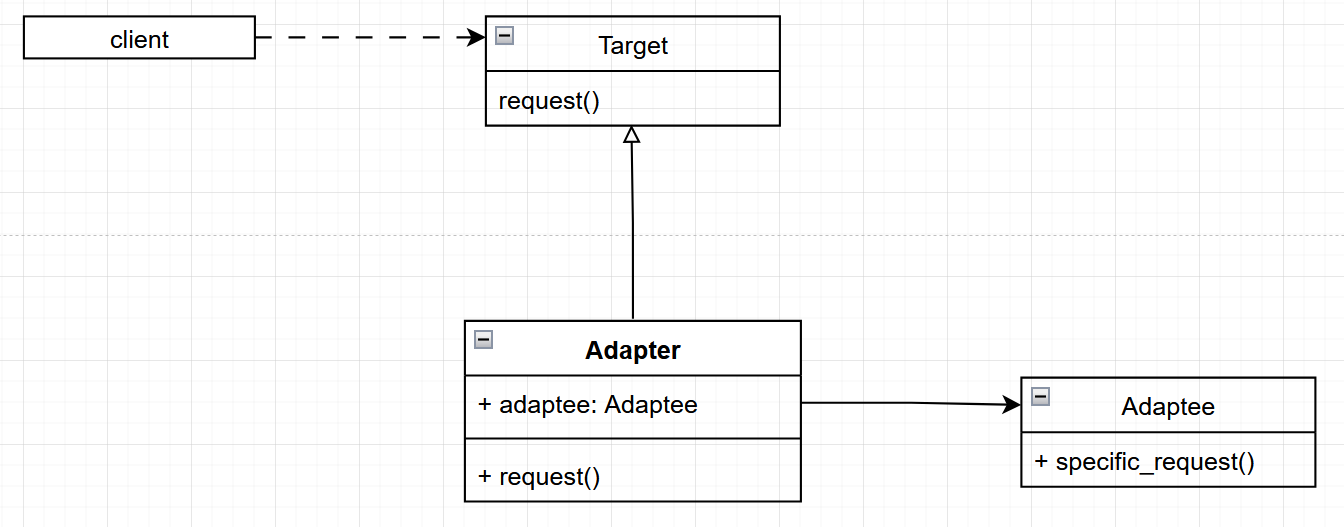

In [ ]:
# Adapter - przekłada interfejs PayPal na PaymentProcessor
class PayPalAdapter(PaymentProcessor):
    def __init__(self, paypal: PayPalAPI):
        self.paypal = paypal  # Kompozycja - zawiera PayPalAPI
    
    def process_payment(self, amount: float):
        # Konwersja: PLN → USD (dla uproszczenia 1:1)
        dollars = amount
        # Przekłada wywołanie na interfejs PayPal
        self.paypal.make_payment(dollars)

In [ ]:
# Użycie adaptera
paypal_api = PayPalAPI()  # Zewnętrzna biblioteka
paypal_adapter = PayPalAdapter(paypal_api)  # Opakowujemy w adapter

# Teraz działa z naszym systemem!
checkout(paypal_adapter, 100.0)

**Jak to działa:**
1. Klient wywołuje `adapter.process_payment(100)`
2. Adapter przekłada to na `paypal.make_payment(100)`
3. PayPal wykonuje płatność

Adapter **tłumaczy** interfejs!

## Rozwiązanie 2: Adapter Klasowy (Class Adapter)

Adapter klasowy używa **dziedziczenia wielokrotnego** - dziedziczy po obu klasach.

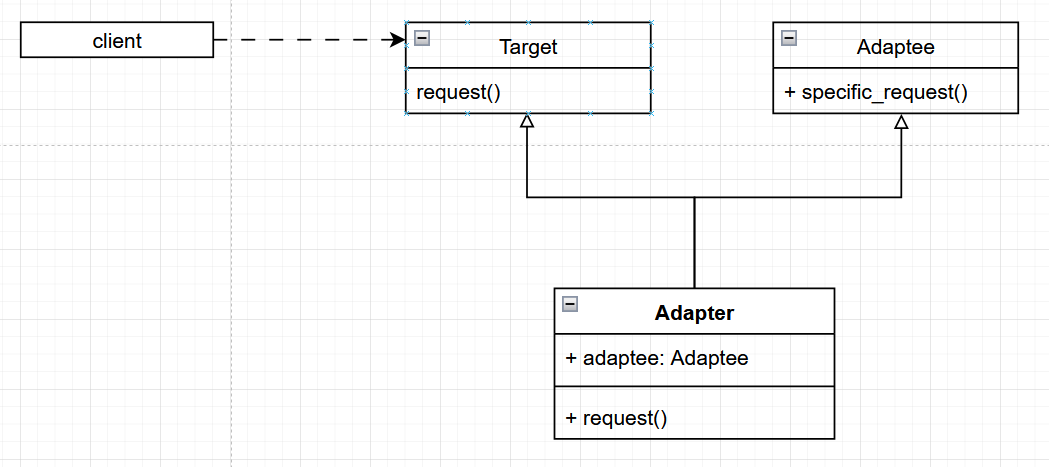

In [ ]:
# Adapter klasowy - dziedziczy po obu klasach
class PayPalClassAdapter(PaymentProcessor, PayPalAPI):
    def process_payment(self, amount: float):
        # Przekłada na metodę z klasy rodzica PayPalAPI
        dollars = amount
        self.make_payment(dollars)  # Metoda z PayPalAPI

In [ ]:
# Użycie
paypal_class_adapter = PayPalClassAdapter()
checkout(paypal_class_adapter, 100.0)

## Różnica: Adapter Obiektowy vs Klasowy

| Cecha | Adapter Obiektowy | Adapter Klasowy |
|-------|-------------------|------------------|
| **Mechanizm** | Kompozycja | Dziedziczenie wielokrotne |
| **Kod** | `self.adaptee.method()` | `super().method()` lub `self.method()` |
| **Elastyczność** | Może adaptować wiele obiektów | Adaptuje tylko jedną klasę |
| **Możliwość nadpisania** | Nie możesz nadpisać metod adaptee | Możesz nadpisać metody z obu klas |
| **Dostępność** | Działa w każdym języku | Tylko języki z wielodziedziczeniem |
| **Rekomendacja** | Preferowany | Tylko gdy potrzebne |

### Wizualizacja różnicy

In [ ]:
# ════════════════════════════════════════════════════════════
# ADAPTER OBIEKTOWY - kompozycja
# ════════════════════════════════════════════════════════════
class ObjectAdapter(PaymentProcessor):
    def __init__(self, adaptee):
        self.adaptee = adaptee  # ◇ Zawiera adaptowany obiekt
    
    def process_payment(self, amount):
        self.adaptee.make_payment(amount)  # Deleguje do zawartego obiektu


# ════════════════════════════════════════════════════════════
# ADAPTER KLASOWY - dziedziczenie
# ════════════════════════════════════════════════════════════
class ClassAdapter(PaymentProcessor, PayPalAPI):
    def process_payment(self, amount):
        self.make_payment(amount)  # Metoda odziedziczona z PayPalAPI

## Pełny przykład - system z wieloma adapterami

In [ ]:
from abc import ABC, abstractmethod

# ════════════════════════════════════════════════════════════
# Interfejs docelowy (Target)
# ════════════════════════════════════════════════════════════
class PaymentProcessor(ABC):
    @abstractmethod
    def process_payment(self, amount: float):
        pass


# ════════════════════════════════════════════════════════════
# Nasza własna implementacja
# ════════════════════════════════════════════════════════════
class StripePayment(PaymentProcessor):
    def process_payment(self, amount: float):
        print(f"✓ Stripe: płatność {amount} zł")


# ════════════════════════════════════════════════════════════
# Zewnętrzne biblioteki (Adaptee) - RÓŻNE interfejsy
# ════════════════════════════════════════════════════════════
class PayPalAPI:
    """Zewnętrzna biblioteka PayPal"""
    def make_payment(self, dollars: float):
        print(f"✓ PayPal: payment ${dollars}")


class BlikService:
    """Zewnętrzna biblioteka Blik"""
    def pay_with_code(self, code: str, amount: float):
        print(f"✓ Blik: płatność {amount} zł kodem {code}")


class BitcoinWallet:
    """Zewnętrzna biblioteka Bitcoin"""
    def send_btc(self, btc_amount: float, address: str):
        print(f"✓ Bitcoin: wysłano {btc_amount} BTC na {address}")


# ════════════════════════════════════════════════════════════
# Adaptery - przekładają interfejsy na PaymentProcessor
# ════════════════════════════════════════════════════════════
class PayPalAdapter(PaymentProcessor):
    def __init__(self, paypal: PayPalAPI):
        self.paypal = paypal
    
    def process_payment(self, amount: float):
        dollars = amount  # Dla uproszczenia PLN = USD
        self.paypal.make_payment(dollars)


class BlikAdapter(PaymentProcessor):
    def __init__(self, blik: BlikService, code: str):
        self.blik = blik
        self.code = code
    
    def process_payment(self, amount: float):
        self.blik.pay_with_code(self.code, amount)


class BitcoinAdapter(PaymentProcessor):
    def __init__(self, wallet: BitcoinWallet, btc_rate: float, address: str):
        self.wallet = wallet
        self.btc_rate = btc_rate  # np. 1 BTC = 200000 PLN
        self.address = address
    
    def process_payment(self, amount: float):
        btc_amount = amount / self.btc_rate
        self.wallet.send_btc(btc_amount, self.address)


# ════════════════════════════════════════════════════════════
# Kod klienta - nie wie o różnicach!
# ════════════════════════════════════════════════════════════
def checkout(processor: PaymentProcessor, amount: float):
    print(f"\nPrzetwarzanie płatności {amount} zł...")
    processor.process_payment(amount)
    print("Płatność zakończona!")

In [ ]:
# Użycie - wszystkie płatności przez ten sam interfejs!
amount = 100.0

# Własna implementacja
stripe = StripePayment()
checkout(stripe, amount)

# Zewnętrzne biblioteki przez adaptery
paypal = PayPalAdapter(PayPalAPI())
checkout(paypal, amount)

blik = BlikAdapter(BlikService(), code="123-456")
checkout(blik, amount)

bitcoin = BitcoinAdapter(BitcoinWallet(), btc_rate=200000, address="1A1zP1...")
checkout(bitcoin, amount)

Zauważ: funkcja `checkout()` **nie wie** jaką płatność przetwarza - wszystkie działają przez ten sam interfejs `PaymentProcessor`!

## Struktura wzorca

**Elementy wzorca Adapter:**

1. **Target** (Cel) - `PaymentProcessor`
   - Interfejs oczekiwany przez klienta
   - Definiuje metody, których klient używa

2. **Adaptee** (Adapterowany) - `PayPalAPI`, `BlikService`
   - Istniejąca klasa z niekompatybilnym interfejsem
   - Zazwyczaj kod zewnętrzny, którego nie możemy zmienić

3. **Adapter** - `PayPalAdapter`, `BlikAdapter`
   - Implementuje interfejs Target
   - Zawiera (lub dziedziczy) Adaptee
   - Przekłada wywołania Target na Adaptee

4. **Client** (Klient) - `checkout()`
   - Używa tylko interfejsu Target
   - Nie wie o Adapter ani Adaptee

## Kiedy używać wzorca Adapter?

Wzorzec Adapter stosuj gdy:

1. **Chcesz używać istniejącej klasy, ale jej interfejs nie pasuje**
   - Zewnętrzna biblioteka ma inny interfejs
   - Legacy code nie pasuje do nowego systemu

2. **Nie możesz lub nie chcesz modyfikować istniejącego kodu**
   - Kod zewnętrzny (biblioteka)
   - Kod w innych zespołach
   - Stabilny kod produkcyjny

3. **Integracja różnych systemów**
   - Nowy system + stary system
   - Wiele zewnętrznych API

**Przykłady praktyczne:**
- Integracja systemów płatności (PayPal, Stripe, Blik)
- Współpraca z legacy code
- Wsparcie różnych baz danych przez jeden interfejs
- Migracja między bibliotekami (stary logger → nowy logger)

## Kiedy NIE używać adaptera?

**Nie używaj adaptera gdy:**

1. **Możesz zmienić oryginalne klasy** - prościej zmienić interfejs bezpośrednio
2. **Interfejsy są bardzo różne** - adapter stałby się zbyt skomplikowany
3. **Potrzebujesz dwukierunkowej komunikacji**

## Podsumowanie

Wzorzec Adapter:
- **Konwertuje** niekompatybilne interfejsy
- **Umożliwia współpracę** klas, które inaczej nie mogłyby działać razem
- **Nie modyfikuje** istniejącego kodu (Open/Closed Principle)
- **Izoluje** kod klienta od zewnętrznych zależności
- **Dodaje warstwę** abstrakcji (niewielki koszt)

**Dwa warianty:**
1. **Adapter Obiektowy** (kompozycja) - preferowany, bardziej elastyczny
2. **Adapter Klasowy** (dziedziczenie) - rzadziej używany, tylko Python/C++

**Kluczowe elementy:**
- **Target** - interfejs oczekiwany przez klienta
- **Adaptee** - istniejąca klasa z innym interfejsem
- **Adapter** - przekłada Target na Adaptee
- **Client** - używa Target, nie wie o Adapter

**Analogia:** Adapter elektryczny - przekłada polski kontakt na amerykański. Działa w jedną stronę. Nie zmienia urządzenia ani gniazdka.